# Using the 8 split datasets based on mass and jet number presence, we try ridge regression to predict outputs

## Dupplicate code from the dataset splitting

We have dupplicated it so as not to have git conflicts, but it should be the same with project1 - Alon.ipynb

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
%load_ext autoreload
%autoreload 2

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [3]:
# remove features with error values
y_jet = []
tx_jet = []
y_jet_nm = []
tx_jet_nm = []
# filtering according to undefinition due to jet number
idx_jet_undef = [np.array([0,1,2,3,7,10,11,13,14,15,16,17,18,19,20,21,29]),
                np.array([0,1,2,3,7,8,9,10,11,13,14,15,16,17,18,19,20,21,23,24,25,29]),
                np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29]),
                np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29])]

# Extra filtering according to definition of mass
idx_jet_undef_nm = [np.array([1,2,3,7,10,11,13,14,15,16,17,18,19,20,21,29]),
                    np.array([1,2,3,7,8,9,10,11,13,14,15,16,17,18,19,20,21,23,24,25,29]),
                    np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29]),
                    np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29])]

for jet in range(4):
    idx_jet = (tX[:,22]==jet) & (tX[:,0] != -999)
    y_jet.append(y[idx_jet])
    tx_jet.append(tX[idx_jet][:,idx_jet_undef[jet]])
    # tx_jet.append(standardize(tX[idx_jet]))

for jet in range(4): # NB : no mass also has dupplicates from data that has mass, to have more data available for training.
    idx_jet = tX[:,22]==jet
    y_jet_nm.append(y[idx_jet])
    tx_jet_nm.append(tX[idx_jet][:,idx_jet_undef_nm[jet]])
    # tx_jet.append(standardize(tX[idx_jet]))

for jet in range(4):
    print('Jet {:} shape is {:}'.format(jet,tx_jet[jet].shape))
    print('Jet no mass {:} shape is {:}'.format(jet,tx_jet_nm[jet].shape))

Jet 0 shape is (73790, 17)
Jet no mass 0 shape is (99913, 16)
Jet 1 shape is (69982, 22)
Jet no mass 1 shape is (77544, 21)
Jet 2 shape is (47427, 29)
Jet no mass 2 shape is (50379, 28)
Jet 3 shape is (20687, 29)
Jet no mass 3 shape is (22164, 28)


## Ridge regression implementation for this set

In [4]:
idx_col_select_split = idx_jet_undef
y_split = []
tx_split = []


for jet in range(4):
    idx_jet = (tX[:,22]==jet) & (tX[:,0] != -999)
    y_split.append(y[idx_jet])
    tx_split.append(tX[idx_jet][:,idx_jet_undef[jet]])

for jet in range(4): # NB : no mass also has dupplicates from data that has mass, to have more data available for training.
    idx_jet = tX[:,22]==jet
    y_split.append(y[idx_jet])
    tx_split.append(tX[idx_jet][:,idx_jet_undef_nm[jet]])
    
for jet in range(4):
    idx_col_select_split.append(idx_jet_undef_nm[jet])
    
# print(y_split)
# print(tx_split[0][0])
for set_i in range(8):
    print(f'Set {set_i} shape is {tx_split[set_i].shape}')

Set 0 shape is (73790, 17)
Set 1 shape is (69982, 22)
Set 2 shape is (47427, 29)
Set 3 shape is (20687, 29)
Set 4 shape is (99913, 16)
Set 5 shape is (77544, 21)
Set 6 shape is (50379, 28)
Set 7 shape is (22164, 28)


For each of the datasets, we now have to train a model. We will use ridge regression, with different lambdas to find the best one. We use a high polynomial expansion because optimising for lambda should mean that any high degree will be compensated by the ridge regression when optimised. Therefore we use any high degree that guarantees our model is not limited by it's complexity.

In [5]:
from lab3_plots import plot_train_test
from th_helpers import build_poly, split_data, compute_rmse
from th_ridge_regression import ridge_regression

In [19]:
def ridge_regression_lambdas(x, y, degree, ratio, seed, lambdas):#=np.logspace(-5, 0, 15)):
    """Performs ridge regression with multiple lambdas."""
    # split the data, and return train and test data: TODO
    train_x, train_y, test_x, test_y = split_data(x, y, ratio, seed)

    # form train and test data with polynomial basis function: TODO
    train_x_aug = build_poly(train_x, degree)
    test_x_aug = build_poly(test_x, degree)

    rmse_tr = []
    rmse_te = []
    
    min_w_te = []
    min_rmse_te = -1
    best_lambda = False
    best_correctness = -1
    
    for ind, lambda_ in enumerate(lambdas):

        # ridge regression with a given lambda        
        w = ridge_regression(train_y, train_x_aug, lambda_)
        
        rmse_tr.append(compute_rmse(train_y, train_x_aug, w))
        rmse_te.append(compute_rmse(test_y, test_x_aug, w))
        
        if rmse_te[ind] < min_rmse_te or min_rmse_te == -1:
            min_rmse_te = rmse_te[ind]
            min_w_te = w
            best_lambda = lambda_
            
        # ***************************************************
#         print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
#                p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
    
    # Compute correctness of best result 
    y_out_test = np.dot(test_x_aug, min_w_te)
    y_out_test[y_out_test>=0] = 1
    y_out_test[y_out_test<0] = -1
    best_correctness = 100*(y_out_test == test_y).tolist().count(True)/y_out_test.shape[0]
            
    # Plot the obtained results
    print(f"Degree={degree}, ratio={np.round(ratio, 3)}, seed={seed}, min test RMSE={np.round(min_rmse_te, 4)}, with correctness={np.round(best_correctness, 2)}% ({len(y_out_test)} test points) and lambda={np.round(best_lambda, 7)}")
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)
    
    return min_rmse_te, min_w_te, best_lambda, best_correctness

# THEOTEST code
# ridge_regression_demo(x=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).T, 
#                       y=np.array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]).T,
#                       degree = 3,
#                       ratio = 0.7,
#                       seed = 56)


Analysing set=0
Degree=5, ratio=0.9, seed=150, min test RMSE=0.742, with correctness =80.7% (7379 test points) and lambda=1.8e-06


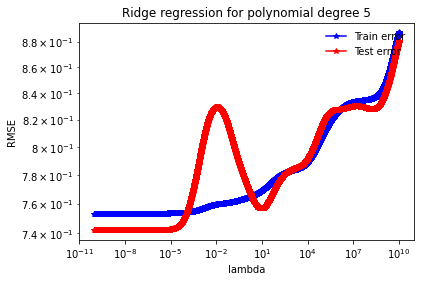

 Set=0 correctness improved degree=5, test correctness=80.7%, for lambda=1.8e-06

Analysing set=0
Degree=6, ratio=0.9, seed=150, min test RMSE=0.7417, with correctness =80.81% (7379 test points) and lambda=1.1e-05


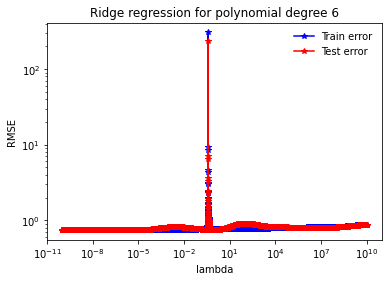

 Set=0 correctness improved degree=6, test correctness=80.81%, for lambda=1.1e-05

Analysing set=0
Degree=7, ratio=0.9, seed=150, min test RMSE=0.7415, with correctness =80.74% (7379 test points) and lambda=0.3899053


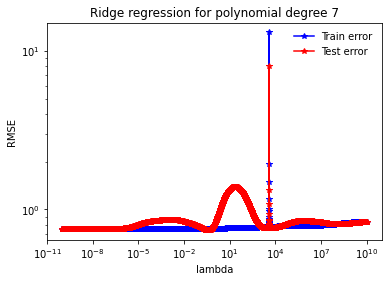


Analysing set=0
Degree=8, ratio=0.9, seed=150, min test RMSE=0.7389, with correctness =80.88% (7379 test points) and lambda=0.184046


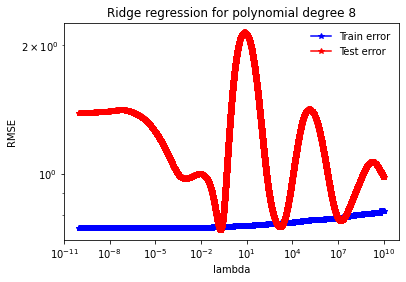

 Set=0 correctness improved degree=8, test correctness=80.88%, for lambda=0.184046

Analysing set=0
Degree=9, ratio=0.9, seed=150, min test RMSE=0.7364, with correctness =81.04% (7379 test points) and lambda=0.000115


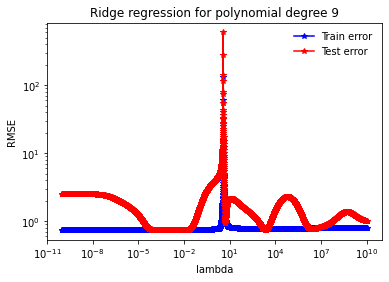

 Set=0 correctness improved degree=9, test correctness=81.04%, for lambda=0.000115

Analysing set=0
Degree=10, ratio=0.9, seed=150, min test RMSE=0.7422, with correctness =80.54% (7379 test points) and lambda=923.20156


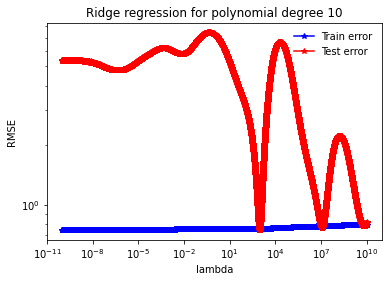


Analysing set=0
Degree=11, ratio=0.9, seed=150, min test RMSE=0.7379, with correctness =80.89% (7379 test points) and lambda=22.863142


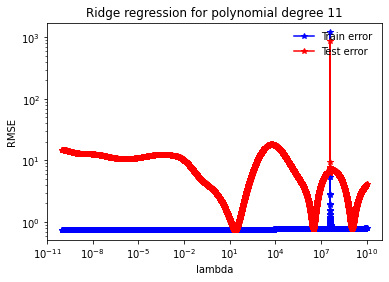


Analysing set=0
Degree=12, ratio=0.9, seed=150, min test RMSE=0.7598, with correctness =79.51% (7379 test points) and lambda=137345293.378707


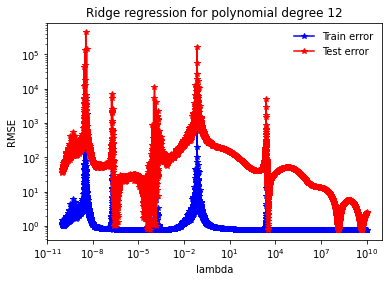


Analysing set=0
Degree=13, ratio=0.9, seed=150, min test RMSE=0.7382, with correctness =81.11% (7379 test points) and lambda=0.0127882


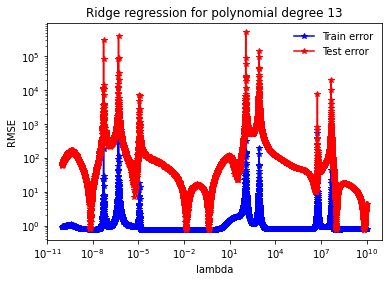

 Set=0 correctness improved degree=13, test correctness=81.11%, for lambda=0.0127882

Analysing set=0
Degree=14, ratio=0.9, seed=150, min test RMSE=0.741, with correctness =80.66% (7379 test points) and lambda=9319.5928538


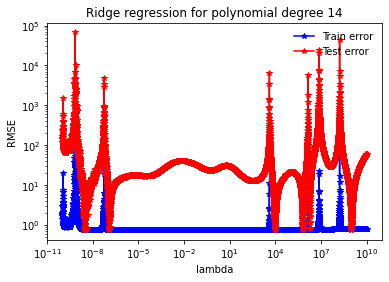


Analysing set=1
Degree=5, ratio=0.9, seed=150, min test RMSE=0.8123, with correctness =76.86% (6998 test points) and lambda=2.7e-06


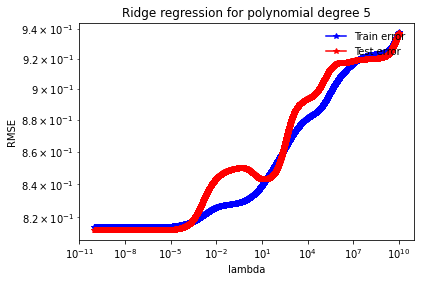

 Set=1 correctness improved degree=5, test correctness=76.86%, for lambda=2.7e-06

Analysing set=1
Degree=6, ratio=0.9, seed=150, min test RMSE=0.8086, with correctness =77.12% (6998 test points) and lambda=4e-07


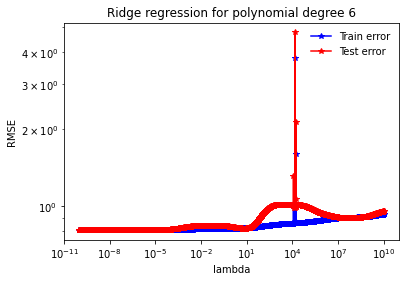

 Set=1 correctness improved degree=6, test correctness=77.12%, for lambda=4e-07

Analysing set=1
Degree=7, ratio=0.9, seed=150, min test RMSE=0.7996, with correctness =78.01% (6998 test points) and lambda=0.0


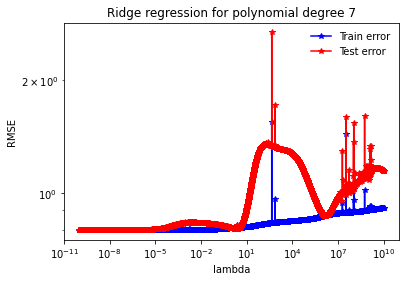

 Set=1 correctness improved degree=7, test correctness=78.01%, for lambda=0.0

Analysing set=1
Degree=8, ratio=0.9, seed=150, min test RMSE=0.786, with correctness =79.24% (6998 test points) and lambda=0.0


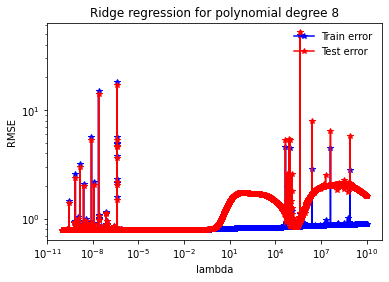

 Set=1 correctness improved degree=8, test correctness=79.24%, for lambda=0.0

Analysing set=1
Degree=9, ratio=0.9, seed=150, min test RMSE=0.783, with correctness =79.22% (6998 test points) and lambda=0.0089288


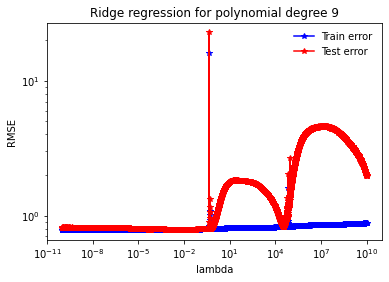


Analysing set=1
Degree=10, ratio=0.9, seed=150, min test RMSE=0.8043, with correctness =77.41% (6998 test points) and lambda=15974.2450379


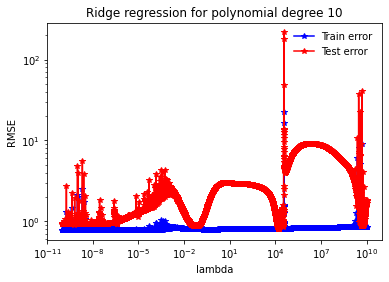


Analysing set=1
Degree=11, ratio=0.9, seed=150, min test RMSE=0.7931, with correctness =78.32% (6998 test points) and lambda=3938.7601556


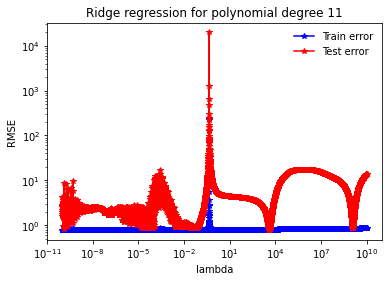


Analysing set=1
Degree=12, ratio=0.9, seed=150, min test RMSE=1.2972, with correctness =76.69% (6998 test points) and lambda=0.0


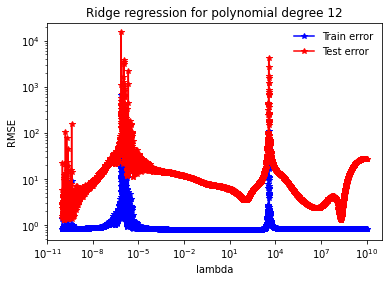


Analysing set=1
Degree=13, ratio=0.9, seed=150, min test RMSE=0.9025, with correctness =78.97% (6998 test points) and lambda=2.6980072


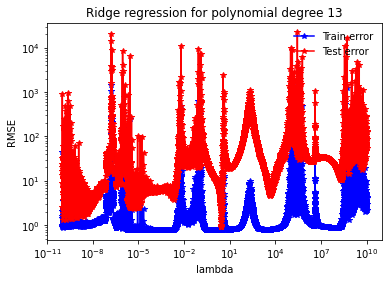


Analysing set=1
Degree=14, ratio=0.9, seed=150, min test RMSE=1.0164, with correctness =76.48% (6998 test points) and lambda=10.2589074


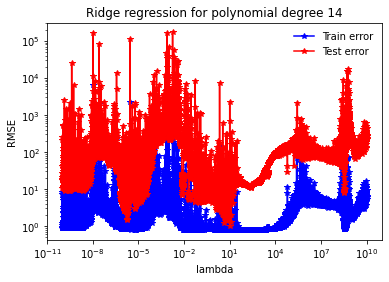


Analysing set=2
Degree=5, ratio=0.9, seed=150, min test RMSE=0.7764, with correctness =80.6% (4743 test points) and lambda=1.43e-05


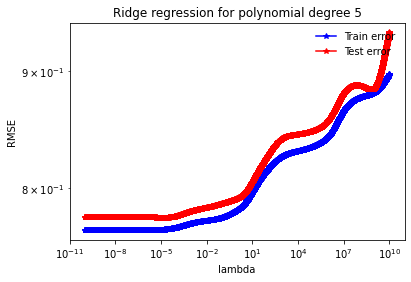

 Set=2 correctness improved degree=5, test correctness=80.6%, for lambda=1.43e-05

Analysing set=2
Degree=6, ratio=0.9, seed=150, min test RMSE=0.7683, with correctness =81.51% (4743 test points) and lambda=4.1e-06


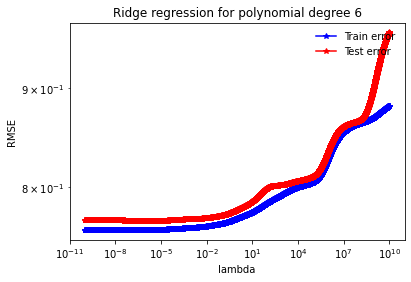

 Set=2 correctness improved degree=6, test correctness=81.51%, for lambda=4.1e-06

Analysing set=2
Degree=7, ratio=0.9, seed=150, min test RMSE=0.761, with correctness =82.29% (4743 test points) and lambda=3e-06


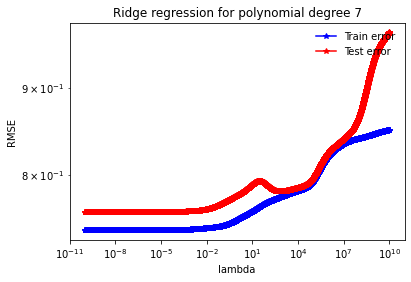

 Set=2 correctness improved degree=7, test correctness=82.29%, for lambda=3e-06

Analysing set=2
Degree=8, ratio=0.9, seed=150, min test RMSE=0.7359, with correctness =82.84% (4743 test points) and lambda=1.58e-05


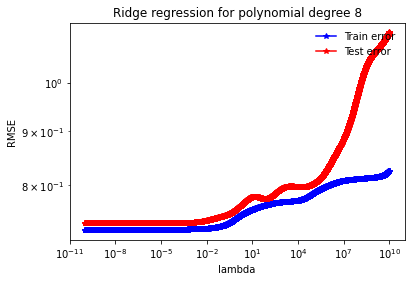

 Set=2 correctness improved degree=8, test correctness=82.84%, for lambda=1.58e-05

Analysing set=2
Degree=9, ratio=0.9, seed=150, min test RMSE=0.7277, with correctness =83.18% (4743 test points) and lambda=2.9e-06


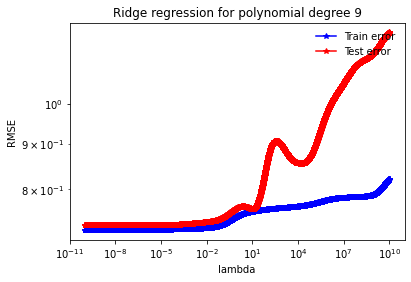

 Set=2 correctness improved degree=9, test correctness=83.18%, for lambda=2.9e-06

Analysing set=2
Degree=10, ratio=0.9, seed=150, min test RMSE=0.7443, with correctness =82.94% (4743 test points) and lambda=0.0


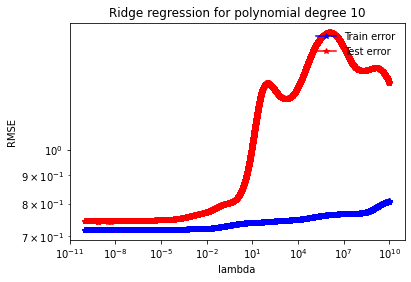


Analysing set=2
Degree=11, ratio=0.9, seed=150, min test RMSE=1.1246, with correctness =78.9% (4743 test points) and lambda=9817461343.942436


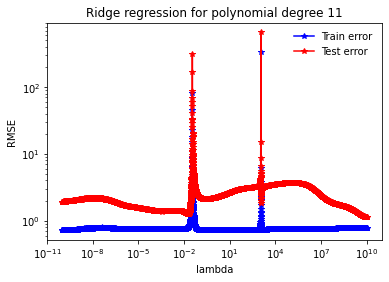


Analysing set=2
Degree=12, ratio=0.9, seed=150, min test RMSE=1.1827, with correctness =80.86% (4743 test points) and lambda=669703530.2392279


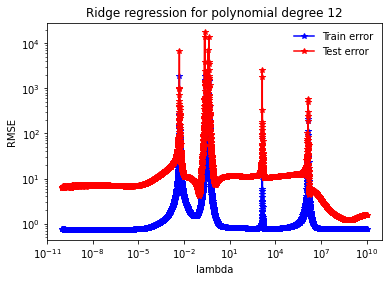


Analysing set=2
Degree=13, ratio=0.9, seed=150, min test RMSE=1.3081, with correctness =81.17% (4743 test points) and lambda=9947175.2623359


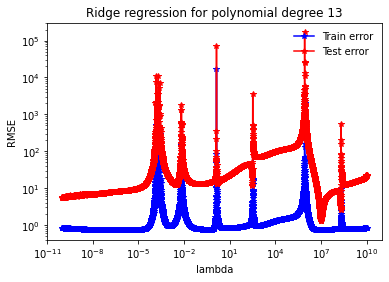


Analysing set=2
Degree=14, ratio=0.9, seed=150, min test RMSE=0.9426, with correctness =79.76% (4743 test points) and lambda=33400454.3985192


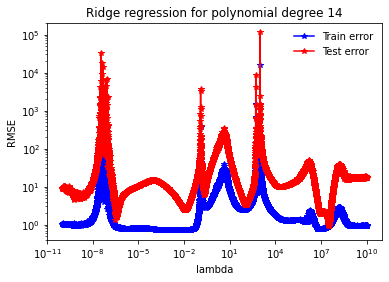


Analysing set=3
Degree=5, ratio=0.9, seed=150, min test RMSE=0.787, with correctness =80.72% (2069 test points) and lambda=2.04e-05


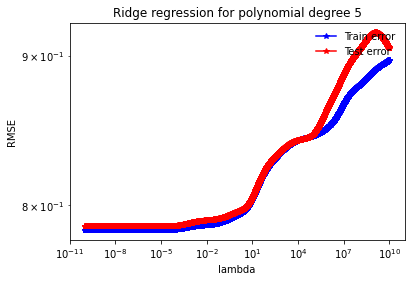

 Set=3 correctness improved degree=5, test correctness=80.72%, for lambda=2.04e-05

Analysing set=3
Degree=6, ratio=0.9, seed=150, min test RMSE=0.8095, with correctness =78.06% (2069 test points) and lambda=263.7801581


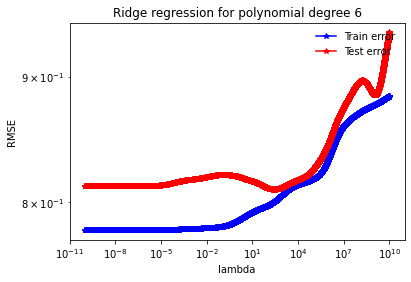


Analysing set=3
Degree=7, ratio=0.9, seed=150, min test RMSE=0.7634, with correctness =80.67% (2069 test points) and lambda=0.0


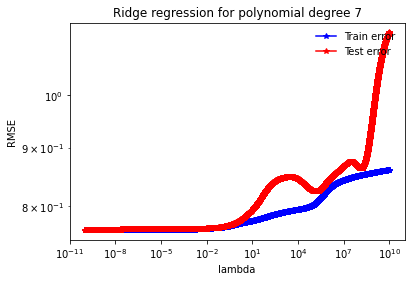


Analysing set=3
Degree=8, ratio=0.9, seed=150, min test RMSE=0.7801, with correctness =81.34% (2069 test points) and lambda=0.6353021


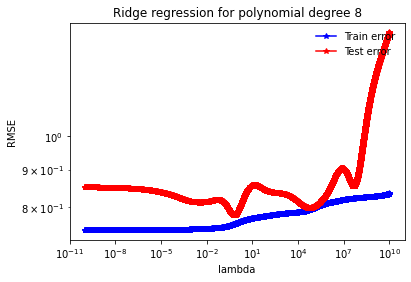

 Set=3 correctness improved degree=8, test correctness=81.34%, for lambda=0.6353021

Analysing set=3
Degree=9, ratio=0.9, seed=150, min test RMSE=0.8549, with correctness =82.31% (2069 test points) and lambda=0.0


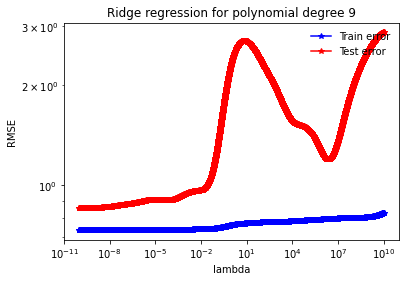

 Set=3 correctness improved degree=9, test correctness=82.31%, for lambda=0.0

Analysing set=3
Degree=10, ratio=0.9, seed=150, min test RMSE=0.8336, with correctness =80.76% (2069 test points) and lambda=2010.6215499


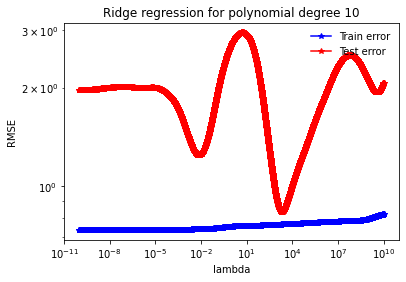


Analysing set=3
Degree=11, ratio=0.9, seed=150, min test RMSE=1.1755, with correctness =81.83% (2069 test points) and lambda=0.8932954


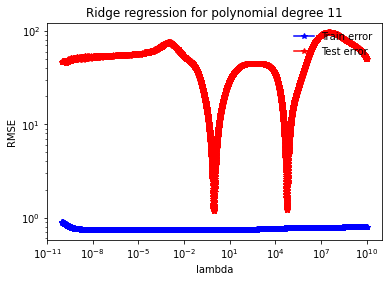


Analysing set=3
Degree=12, ratio=0.9, seed=150, min test RMSE=2.5834, with correctness =78.83% (2069 test points) and lambda=36429.7462017


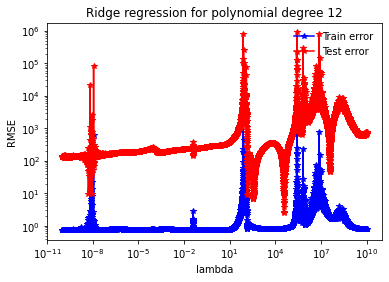


Analysing set=3
Degree=13, ratio=0.9, seed=150, min test RMSE=4.9932, with correctness =76.27% (2069 test points) and lambda=3.27e-05


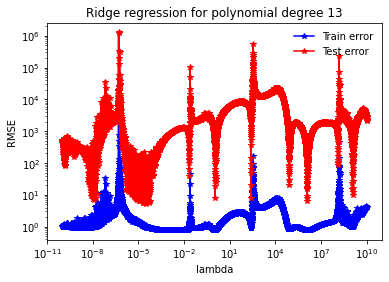


Analysing set=3
Degree=14, ratio=0.9, seed=150, min test RMSE=2.0113, with correctness =80.52% (2069 test points) and lambda=1457526.1711499


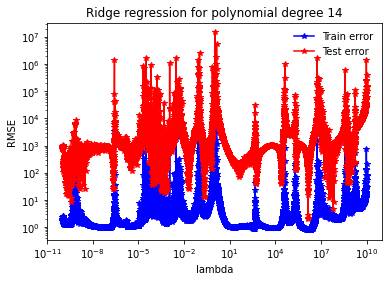


Analysing set=4
Degree=5, ratio=0.9, seed=150, min test RMSE=0.6936, with correctness =83.42% (9991 test points) and lambda=0.0001502


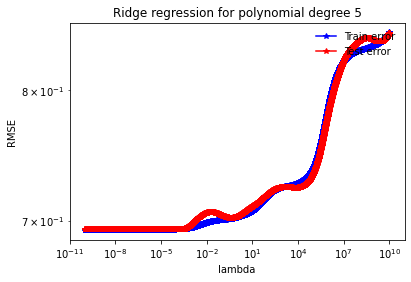

 Set=4 correctness improved degree=5, test correctness=83.42%, for lambda=0.0001502

Analysing set=4
Degree=6, ratio=0.9, seed=150, min test RMSE=0.6934, with correctness =83.55% (9991 test points) and lambda=6.47e-05


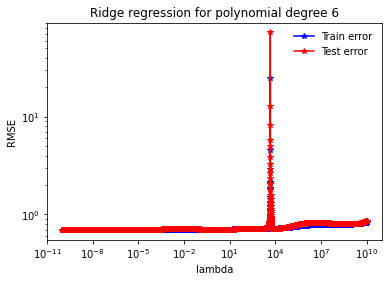

 Set=4 correctness improved degree=6, test correctness=83.55%, for lambda=6.47e-05

Analysing set=4
Degree=7, ratio=0.9, seed=150, min test RMSE=0.6927, with correctness =83.17% (9991 test points) and lambda=3.1992671


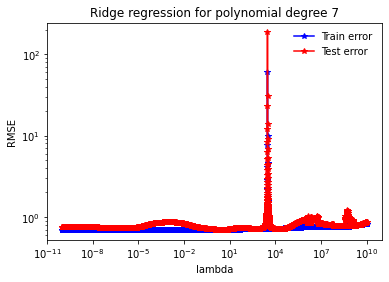


Analysing set=4
Degree=8, ratio=0.9, seed=150, min test RMSE=0.6881, with correctness =83.68% (9991 test points) and lambda=0.0913895


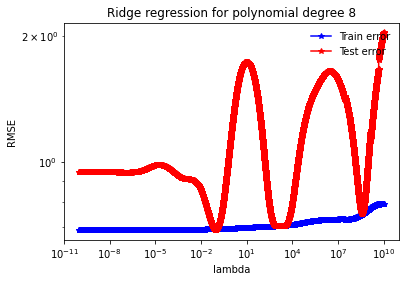

 Set=4 correctness improved degree=8, test correctness=83.68%, for lambda=0.0913895

Analysing set=4
Degree=9, ratio=0.9, seed=150, min test RMSE=0.7158, with correctness =83.3% (9991 test points) and lambda=962.2730655


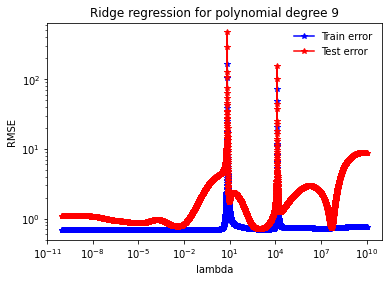


Analysing set=4
Degree=10, ratio=0.9, seed=150, min test RMSE=0.6861, with correctness =83.71% (9991 test points) and lambda=0.0046427


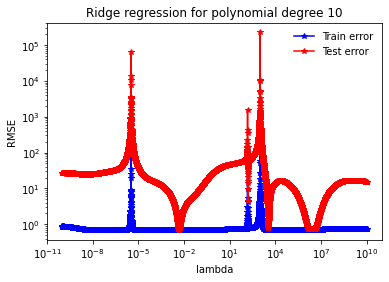

 Set=4 correctness improved degree=10, test correctness=83.71%, for lambda=0.0046427

Analysing set=4
Degree=11, ratio=0.9, seed=150, min test RMSE=0.6852, with correctness =83.94% (9991 test points) and lambda=0.000261


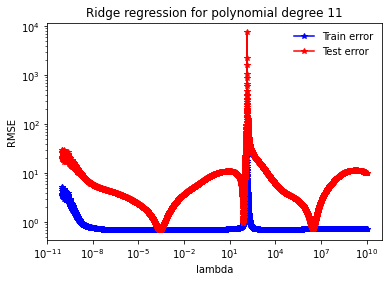

 Set=4 correctness improved degree=11, test correctness=83.94%, for lambda=0.000261

Analysing set=4
Degree=12, ratio=0.9, seed=150, min test RMSE=0.6848, with correctness =83.84% (9991 test points) and lambda=0.0017568


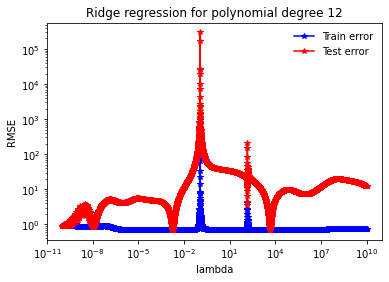


Analysing set=4
Degree=13, ratio=0.9, seed=150, min test RMSE=0.6907, with correctness =83.75% (9991 test points) and lambda=0.0096117


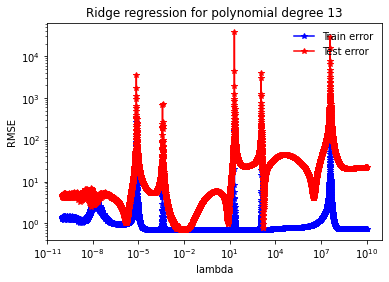


Analysing set=4
Degree=14, ratio=0.9, seed=150, min test RMSE=0.6882, with correctness =83.74% (9991 test points) and lambda=14.0966174


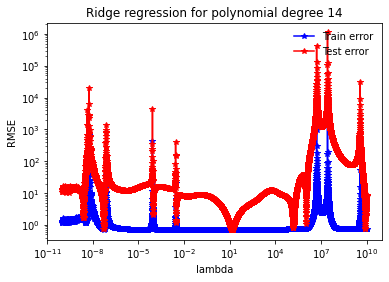


Analysing set=5
Degree=5, ratio=0.9, seed=150, min test RMSE=0.8079, with correctness =77.6% (7754 test points) and lambda=0.0


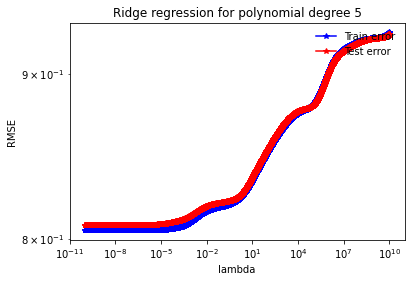

 Set=5 correctness improved degree=5, test correctness=77.6%, for lambda=0.0

Analysing set=5
Degree=6, ratio=0.9, seed=150, min test RMSE=0.8068, with correctness =77.38% (7754 test points) and lambda=0.0


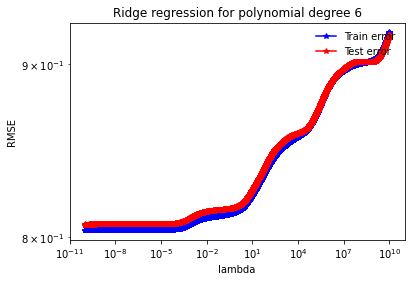


Analysing set=5
Degree=7, ratio=0.9, seed=150, min test RMSE=0.8064, with correctness =77.12% (7754 test points) and lambda=0.0


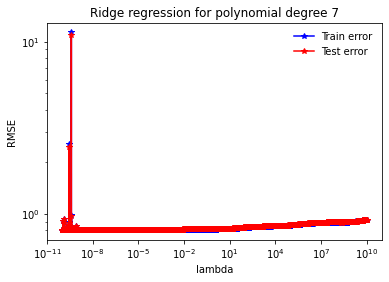


Analysing set=5
Degree=8, ratio=0.9, seed=150, min test RMSE=0.7994, with correctness =77.78% (7754 test points) and lambda=0.0


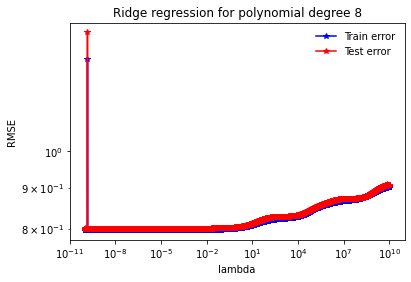

 Set=5 correctness improved degree=8, test correctness=77.78%, for lambda=0.0

Analysing set=5
Degree=9, ratio=0.9, seed=150, min test RMSE=0.7936, with correctness =78.15% (7754 test points) and lambda=3.6e-05


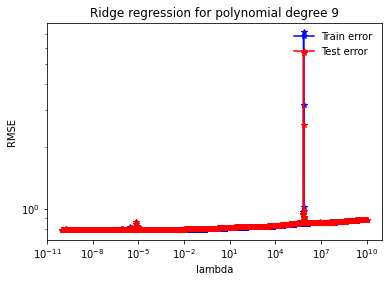

 Set=5 correctness improved degree=9, test correctness=78.15%, for lambda=3.6e-05

Analysing set=5
Degree=10, ratio=0.9, seed=150, min test RMSE=0.791, with correctness =78.37% (7754 test points) and lambda=5.3e-06


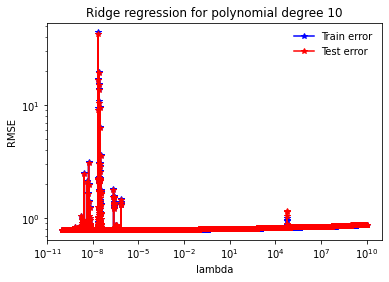

 Set=5 correctness improved degree=10, test correctness=78.37%, for lambda=5.3e-06

Analysing set=5
Degree=11, ratio=0.9, seed=150, min test RMSE=0.7941, with correctness =78.4% (7754 test points) and lambda=1e-07


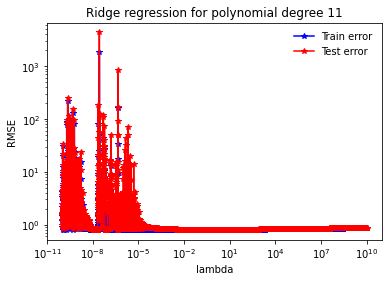

 Set=5 correctness improved degree=11, test correctness=78.4%, for lambda=1e-07

Analysing set=5
Degree=12, ratio=0.9, seed=150, min test RMSE=0.8019, with correctness =78.14% (7754 test points) and lambda=0.2182398


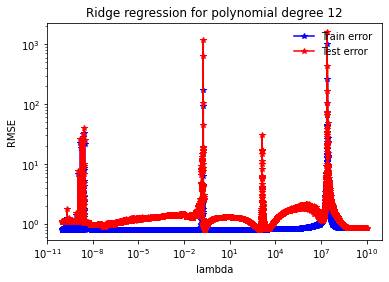


Analysing set=5
Degree=13, ratio=0.9, seed=150, min test RMSE=0.7968, with correctness =78.33% (7754 test points) and lambda=0.0001078


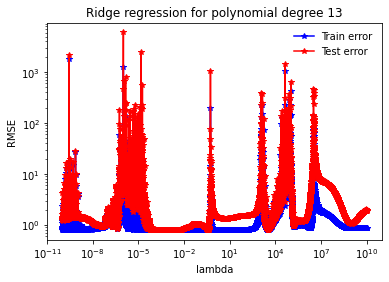


Analysing set=5
Degree=14, ratio=0.9, seed=150, min test RMSE=0.8085, with correctness =78.04% (7754 test points) and lambda=1.640671


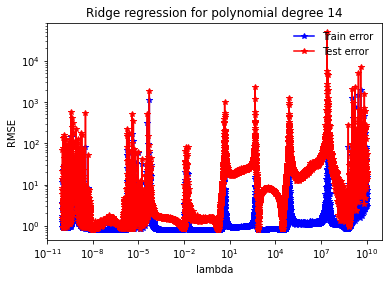


Analysing set=6
Degree=5, ratio=0.9, seed=150, min test RMSE=0.7913, with correctness =79.02% (5038 test points) and lambda=0.0


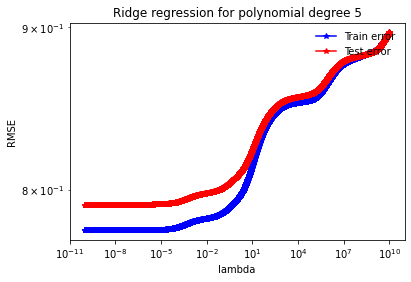

 Set=6 correctness improved degree=5, test correctness=79.02%, for lambda=0.0

Analysing set=6
Degree=6, ratio=0.9, seed=150, min test RMSE=0.789, with correctness =79.06% (5038 test points) and lambda=0.0


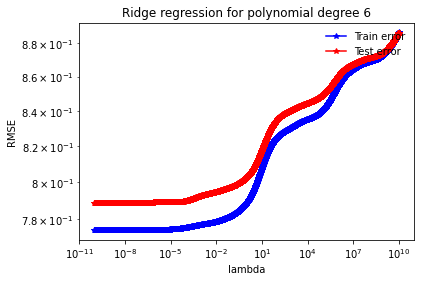

 Set=6 correctness improved degree=6, test correctness=79.06%, for lambda=0.0

Analysing set=6
Degree=7, ratio=0.9, seed=150, min test RMSE=0.7875, with correctness =78.92% (5038 test points) and lambda=0.0


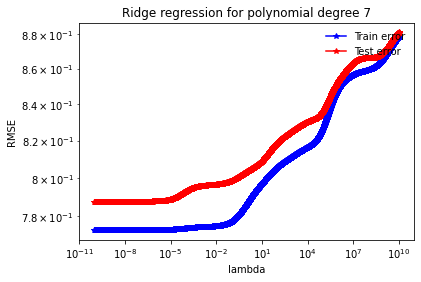


Analysing set=6
Degree=8, ratio=0.9, seed=150, min test RMSE=0.7842, with correctness =79.44% (5038 test points) and lambda=7.99e-05


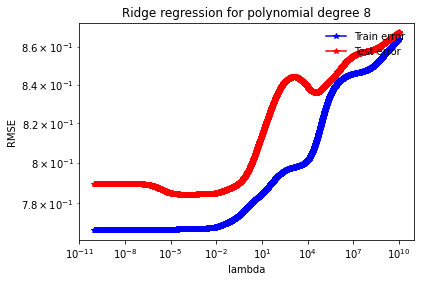

 Set=6 correctness improved degree=8, test correctness=79.44%, for lambda=7.99e-05

Analysing set=6
Degree=9, ratio=0.9, seed=150, min test RMSE=0.7826, with correctness =79.75% (5038 test points) and lambda=1e-07


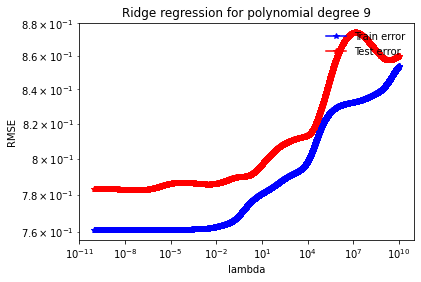

 Set=6 correctness improved degree=9, test correctness=79.75%, for lambda=1e-07

Analysing set=6
Degree=10, ratio=0.9, seed=150, min test RMSE=0.7807, with correctness =79.48% (5038 test points) and lambda=0.0203625


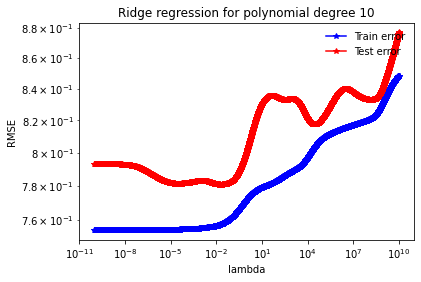


Analysing set=6
Degree=11, ratio=0.9, seed=150, min test RMSE=0.7947, with correctness =79.97% (5038 test points) and lambda=0.0


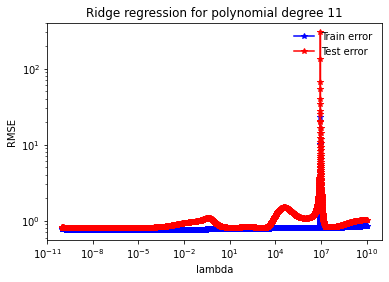

 Set=6 correctness improved degree=11, test correctness=79.97%, for lambda=0.0

Analysing set=6
Degree=12, ratio=0.9, seed=150, min test RMSE=0.7752, with correctness =80.01% (5038 test points) and lambda=1.28e-05


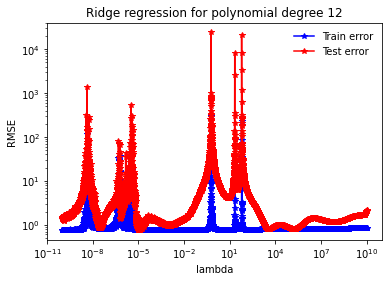

 Set=6 correctness improved degree=12, test correctness=80.01%, for lambda=1.28e-05

Analysing set=6
Degree=13, ratio=0.9, seed=150, min test RMSE=0.8026, with correctness =78.05% (5038 test points) and lambda=0.0


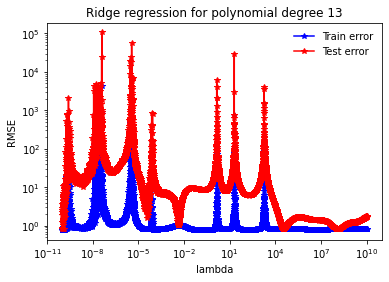


Analysing set=6
Degree=14, ratio=0.9, seed=150, min test RMSE=0.8222, with correctness =77.01% (5038 test points) and lambda=245379899.3003462


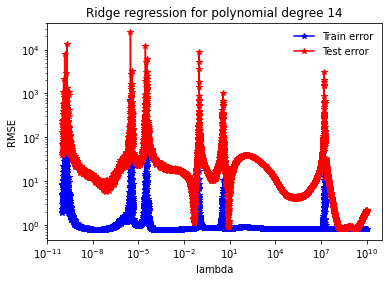


Analysing set=7
Degree=5, ratio=0.9, seed=150, min test RMSE=0.779, with correctness =79.65% (2216 test points) and lambda=7.67e-05


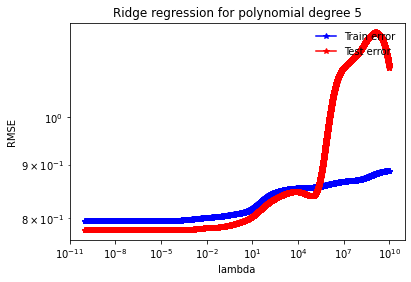

 Set=7 correctness improved degree=5, test correctness=79.65%, for lambda=7.67e-05

Analysing set=7
Degree=6, ratio=0.9, seed=150, min test RMSE=0.7759, with correctness =79.6% (2216 test points) and lambda=0.0018144


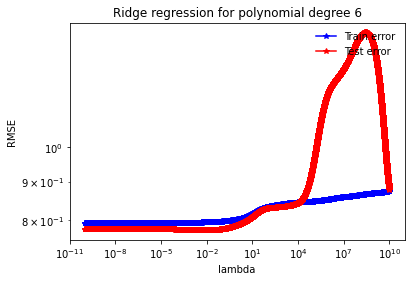


Analysing set=7
Degree=7, ratio=0.9, seed=150, min test RMSE=0.7981, with correctness =79.42% (2216 test points) and lambda=0.0


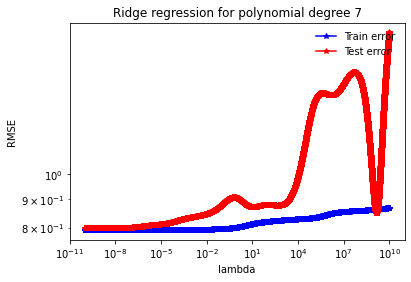


Analysing set=7
Degree=8, ratio=0.9, seed=150, min test RMSE=0.8071, with correctness =78.97% (2216 test points) and lambda=10.6439472


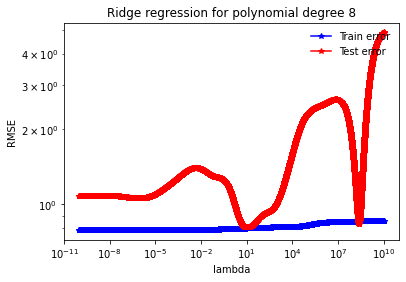


Analysing set=7
Degree=9, ratio=0.9, seed=150, min test RMSE=0.7719, with correctness =79.33% (2216 test points) and lambda=0.4999999


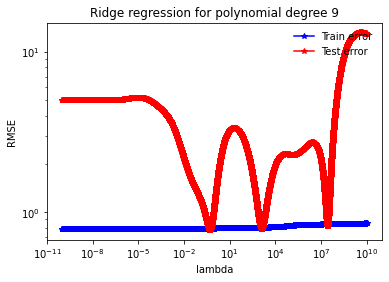


Analysing set=7
Degree=10, ratio=0.9, seed=150, min test RMSE=0.7595, with correctness =80.87% (2216 test points) and lambda=0.0003109


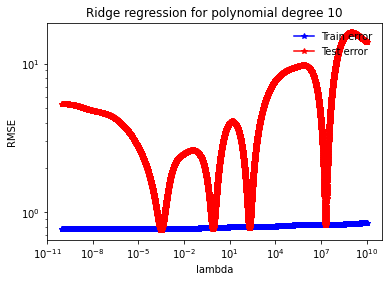

 Set=7 correctness improved degree=10, test correctness=80.87%, for lambda=0.0003109

Analysing set=7
Degree=11, ratio=0.9, seed=150, min test RMSE=0.8144, with correctness =78.75% (2216 test points) and lambda=12173.306052


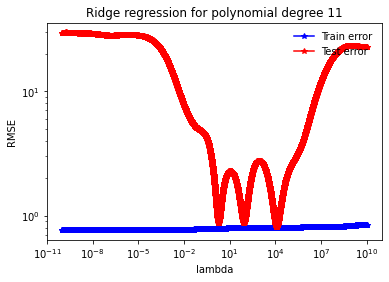


Analysing set=7
Degree=12, ratio=0.9, seed=150, min test RMSE=0.8963, with correctness =78.38% (2216 test points) and lambda=90739374.1635728


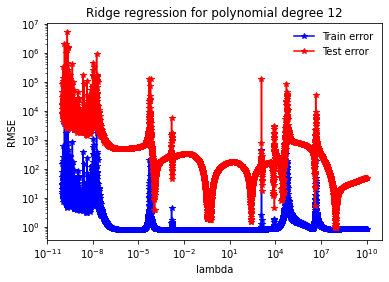


Analysing set=7
Degree=13, ratio=0.9, seed=150, min test RMSE=0.9655, with correctness =80.42% (2216 test points) and lambda=0.1422051


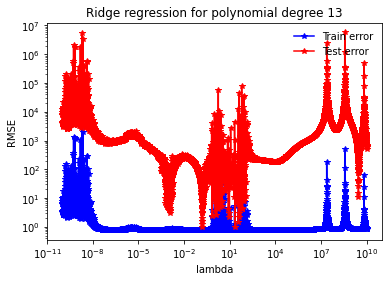


Analysing set=7
Degree=14, ratio=0.9, seed=150, min test RMSE=1.4092, with correctness =77.26% (2216 test points) and lambda=1.2560586


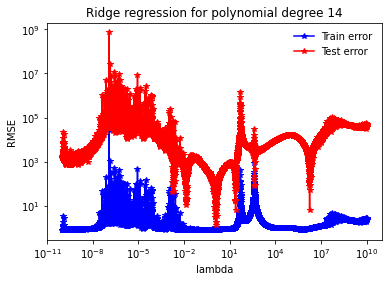



Final best correctness=[81.10855129421331, 79.23692483566734, 83.1752055660974, 82.31029482841953, 83.93554198778901, 78.39824606654629, 80.01190948789203, 80.86642599277978], 
 degrees=[13, 8, 9, 9, 11, 11, 12, 10], 
  lambdas=[0.012788237140267267, 4.967863071785483e-09, 2.9137108061437027e-06, 1.0046162529674374e-10, 0.0002610006952253783, 7.521208509981752e-08, 1.2779405506531912e-05, 0.0003109204337711026]


In [28]:
seed = 150
degree = 8
degrees = [degree+5 for degree in range(10)]
split_ratio = 0.9
lambdas = np.logspace(-10, 10, 10000)
best_degrees_hyp = 8*[0]
best_lambdas_hyp = 8*[-1]
best_correctness_hyp = 8*[-1]
best_ws_split = [8*[]] # To check whether predictions from training on split set is better than whole set 

for set_i in range(8):
    for degree in degrees:
        print(f"\nAnalysing set={set_i}, degree={degree}")
        _, best_w_split, best_lambda, best_correctness = ridge_regression_lambdas(tx_split[set_i], y_split[set_i], degree, split_ratio, seed, lambdas)
        
        if best_correctness > best_correctness_hyp[set_i]:
            best_correctness_hyp[set_i] = best_correctness
            best_lambdas_hyp[set_i] = best_lambda
            best_degrees_hyp[set_i] = degree
            best_ws_split[set_i] = best_w_split
            print(f"\x1B[42m Set={set_i} correctness improved degree={degree}, test correctness={np.round(best_correctness, 2)}%, for lambda={np.round(best_lambda, 7)}\x1B[0m")

print(f"\n\nFinal best correctness={best_correctness_hyp}, \n degrees={best_degrees_hyp}, \n  lambdas={best_lambdas_hyp}")            


## Investigations into specific sets :

### Set 7

In [ ]:
seed = 150
degree = 7
split_ratio = 0.9
lambdas = np.logspace(-5, 10, 1000)

set_i = 7

print(f"\nAnalysing set={set_i}")
min_rmse_te, min_w_te, best_lambda = ridge_regression_lambdas(tx_split[set_i], y_split[set_i], degree, split_ratio, seed, lambdas)

## Now actual ridge regression with output file

We need to split the test data the same way, but keeping the ids in order to reconstruct it afterwards.

In [32]:
# parameters chosen from above tests
best_degrees = [13, 8, 9, 9, 11, 11, 12, 10]
best_lambdas = [0.012788237140267267, 4.967863071785483e-09, 2.9137108061437027e-06, 1.0046162529674374e-10, 0.0002610006952253783, 7.521208509981752e-08, 1.2779405506531912e-05, 0.0003109204337711026]
print(best_degrees, best_lambdas)

# results after 12 hour run with degrees = [degree+5 for degree in range(10)], split_ratio = 0.9, lambdas = np.logspace(-10, 10, 10000)
# Final best correctness=[81.10855129421331, 79.23692483566734, 83.1752055660974, 82.31029482841953, 83.93554198778901, 78.39824606654629, 80.01190948789203, 80.86642599277978], 
# degrees=[13, 8, 9, 9, 11, 11, 12, 10], 
# lambdas=[0.012788237140267267, 4.967863071785483e-09, 2.9137108061437027e-06, 1.0046162529674374e-10, 0.0002610006952253783, 7.521208509981752e-08, 1.2779405506531912e-05, 0.0003109204337711026]

[13, 8, 9, 9, 11, 11, 12, 10] [0.012788237140267267, 4.967863071785483e-09, 2.9137108061437027e-06, 1.0046162529674374e-10, 0.0002610006952253783, 7.521208509981752e-08, 1.2779405506531912e-05, 0.0003109204337711026]


We will first re-train our 8 models on the whole data, with the parameters found. As we checked for the best model complexity still avoiding overfitting, we will now train on all the train data. Because this is increasing the data on which the model trains, it should in fact reduce overfitting since we keep the same, therefore we do not split the data to check. We will in any case have AIcrowd to indicate if that was a good choice or not.

After getting the model for each set, we will go through the original set and predict the outcome. We do this by iterating as we want to keep the right id for each datapoint.

In [33]:
set_ws = []
for set_i in range(8):
    train_x_aug = build_poly(tx_split[set_i], best_degrees[set_i])
    
    set_ws.append( ridge_regression(y_split[set_i], train_x_aug, best_lambdas[set_i]) )
    print(f"train_x_aug shape={train_x_aug.shape} w_shape={set_ws[set_i].shape}")

train_x_aug shape=(73790, 222) w_shape=(222,)
train_x_aug shape=(69982, 177) w_shape=(177,)
train_x_aug shape=(47427, 262) w_shape=(262,)
train_x_aug shape=(20687, 262) w_shape=(262,)
train_x_aug shape=(99913, 177) w_shape=(177,)
train_x_aug shape=(77544, 232) w_shape=(232,)
train_x_aug shape=(50379, 337) w_shape=(337,)
train_x_aug shape=(22164, 281) w_shape=(281,)


In [35]:
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [36]:
print(tX_test.shape)

(568238, 30)


In [37]:
def compute_out_y(tX, ws, degrees):
    y_out = np.empty(tX.shape[0])

    for point_i, datapoint in enumerate(tX):
        jet_num = int(datapoint[22])
        if datapoint[0] != -999: # Mass is defined
            correct_set = datapoint[idx_jet_undef[jet_num]]
            correct_set_aug = build_poly(correct_set, degrees[jet_num])
            y_out[point_i] = np.dot(correct_set_aug, ws[jet_num])
        else : # Mass is undefined
            correct_set = datapoint[idx_jet_undef_nm[jet_num]]
            correct_set_aug = build_poly(correct_set, degrees[jet_num+4]) # offset of 4 because no mass ws start at index 4
            y_out[point_i] = np.dot(correct_set_aug, ws[jet_num+4])         

    y_out[y_out>=0] = 1
    y_out[y_out<0] = -1  
    
    return y_out

In [38]:
y_out_train_check = compute_out_y(tX, set_ws, best_degrees)

print(f"Correctness for all train set={100*(y_out_train_check == y).tolist().count(True)/y_out_train_check.shape[0]}%")

Correctness for all train set=82.6852%


Now apply to test set and generate csv file

In [39]:
y_out_test = compute_out_y(tX_test, set_ws, best_degrees)
print(f"Y test out shape={y_out_test.shape} and original tX_test shape={tX_test.shape}")

Y test out shape=(568238,) and original tX_test shape=(568238, 30)


In [40]:
LAST_OUT_NAME = f"submit_ridge_split8sets.csv"
create_csv_submission(ids_test, y_out_test, LAST_OUT_NAME)
print("Correctly created file with name=", LAST_OUT_NAME)

Correctly created file with name= submit_ridge_split8sets.csv
